## Estimate weight of long range edges using appropriate penalizations for likelihoods

### Two models: 
1. instantantenous admixture (akin to TreeMix model) - assume a single long range edge from $s$ to $d$ with some shared portion of the genome $c$. So, then $L^{\dagger_n}_{s,d} = (1-c) \times L^{\dagger_o}_{s,d} + c \times L^{\dagger_o}_{s,s}$

In [7]:
%load_ext autoreload
%autoreload 2

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy
import pandas as pd
import multiprocessing as mp
from scipy.stats.distributions import chi2
import scipy as sp

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import matplotlib.colors as colors

# feems
from feems import SpatialGraph, Viz, Objective
from feems.joint_ver import Joint_SpatialGraph, Joint_Objective
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes
from feems.spatial_graph import query_node_attributes
from feems.objective import comp_mats
from feems.cross_validation import run_cv
from feems.helper_funcs import * #plot_default_vs_long_range, comp_genetic_vs_fitted_distance, plot_estimated_vs_simulated_edges

# popgen
import msprime
import tskit
import allel

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams['axes.axisbelow'] = True

Simulating ~SNP 0
Simulating ~SNP 1000
Simulating ~SNP 0
Simulating ~SNP 1000


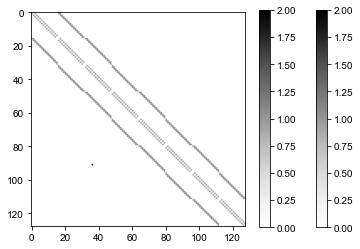

In [1230]:
n_rows, n_columns = 8, 16
graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5)

lrn = [(36,91)]

## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_startpt=5.5, barrier_endpt=5.5,barrier_w=1.0, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[2.])

gen_test_1e = simulate_genotypes(graph, target_n_snps=1200, n_print=500, mu=1e-1)
gen_test_1e_asym = simulate_genotypes(graph, target_n_snps=1200, mu=1e-1, n_print=500, asymmetric=True, long_range_nodes=lrn, long_range_edges=[2.])

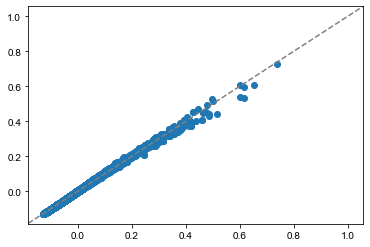

In [1269]:
# sp_Graph_sym = Joint_SpatialGraph(gen_test_1e, coord, grid, edge_def)
# sp_Graph_sym.fit(lamb=3., optimize_q='n-dim')
# obj_sym = Joint_Objective(sp_Graph_sym); obj_sym.inv(); obj_sym.grad(reg=False)

# sp_Graph_asym = Joint_SpatialGraph(gen_test_1e_asym, coord, grid, edge_def)
# sp_Graph_asym.fit(lamb=3., optimize_q='n-dim')
# obj_asym = Joint_Objective(sp_Graph_asym); obj_asym.inv(); obj_asym.grad(reg=False)

# fig = plt.figure(dpi=110)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_Graph_asym, projection=ccrs.Mercator(), edge_width=2, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
#         obs_node_size=7.5, sample_pt_color="black", 
#         cbar_font_size=10)
# v.draw_edges(use_weights=True)
# v.draw_edge_colorbar()
# v.draw_obs_nodes(use_ids=False)
# plt.scatter(sp_Graph_asym.w,sp_Graph_sym.w,alpha=0.7); plt.axline((1,1),slope=1,color='grey',ls='--')
plt.scatter(obj_sym.Linv, obj_asym.Linv); plt.axline((1,1),slope=1,color='grey',ls='--')

In [861]:
## fit_cov = obj.Linv_block['oo'] - 1/d + sp_graph.q_inv_diag.toarray()
sp_Graph_def_jt = Joint_SpatialGraph(gen_test_1e, coord, grid, edge_def)
sp_Graph_def_jt.fit(lamb=3., optimize_q='n-dim')
obj_jt = Joint_Objective(sp_Graph_def_jt); obj_jt.inv(); obj_jt.grad(reg=False)
# obj_jt.Linv_block["oo"]

constant-w/variance fit, converged in 121 iterations, train_loss=7011.4510086
lambda=3.0000000, alpha=0.5681798, converged in 11 iterations, train_loss=6087.7189864


In [1250]:
def get_best_lre(sp_graph_lr, gen_test, coord, grid, edge_def, k=5, nfolds=None, lamb_cv=3., top=20):
    sp_graph_lr.fit(lamb=lamb_cv, optimize_q='n-dim', lamb_q=1., alpha_q=1./np.mean(sp_graph_lr.s2))
    edges_lr = deepcopy(edge_def)
    edges_lr = edges_lr.tolist()
    ll_edges = np.empty((top,k))
    top_edges = pd.DataFrame(index=range(top), columns=range(k))
    for ik in range(k):
        print("Starting search for edge {}...".format(ik+1))
        lrn = comp_genetic_vs_fitted_distance(sp_graph_lr, n_lre=top, lamb=lamb_cv, plotFig=False, joint=True)
        # lrn = list(map(tuple,node_to_pop['nodes'][np.ravel(max_res_nodes)].values.reshape(top,2)))
        edges_lr.append(list(x+1 for x in lrn[0]))
        # print(len(edges_lr))
        sp_graph_lr = Joint_SpatialGraph(gen_test, coord, grid, np.array(edges_lr), long_range_edges=lrn[0:1])
        sp_graph_lr.fit(lamb=lamb_cv, optimize_q='n-dim', lamb_q=1., alpha_q=1./np.mean(sp_graph_lr.s2),verbose=False)
        # print(len(sp_graph_lr.edges))
        obj_lr = Joint_Objective(sp_graph_lr); obj_lr.inv(); 
        ll_edges[0,ik] = -obj_lr.neg_log_lik()
        for ie, e in enumerate(lrn[1:]):
            ll_edges[ie+1,ik] = sub_edge_get_ll(sp_graph_lr, lrn[ie], lrn[ie+1], 3.)
        print("{}, found at index {}.".format(lrn[np.argmax(ll_edges[:,ik])], np.argmax(ll_edges[:,ik])))
        top_edges.iloc[:,ik] = lrn
        sub_edge_get_ll(sp_graph_lr, lrn[len(lrn)-1], lrn[np.argmax(ll_edges[:,ik])], 3.)
        edges_lr = [list(x+1 for x in lrn[np.argmax(ll_edges[:,ik])]) if item == list(x+1 for x in lrn[0]) else item for item in edges_lr] 
        # print(len(edges_lr))
        # print(lrn, ll_edges[:,ik])
        # edges_lr.append(list(x+1 for x in lrn[np.argmax(ll_edges[:,ik])]))
        # sp_graph = Joint_SpatialGraph(gen_test, coord, grid, np.array(edges_lr), long_range_edges=[lrn[np.argmax(ll_edges[:,ik])]])
        sp_graph_lr.fit(lamb=lamb_cv, optimize_q='n-dim', lamb_q=1., alpha_q=1./np.mean(sp_graph_lr.s2))
        
    return ll_edges, top_edges

In [1267]:
# comp_genetic_vs_fitted_distance(sp_Graph_sym, n_lre=10, lamb=3., plotFig=False, joint=True)
# get_best_lre(sp_Graph_sym,gen_test_1e_asym,coord,grid,edge_def,top=10,k=2) #-> (36,91) found as TRUE EDGE!
edges_lr = deepcopy(edge_def)
edges_lr = edges_lr.tolist()
edges_lr.append(list(x+1 for x in (36,91)))
sp_graph_lr = Joint_SpatialGraph(gen_test_1e, coord, grid, np.array(edges_lr), long_range_edges=[(36,91)])
sp_graph_lr.fit(lamb=3.,optimize_q='n-dim')
print(sp_graph_lr.w[sp_graph_lr.lre_idx])
sp_graph_lr = Joint_SpatialGraph(gen_test_1e_asym, coord, grid, np.array(edges_lr), long_range_edges=[(36,91)])
sp_graph_lr.fit(lamb=3.,optimize_q='n-dim')
print(sp_graph_lr.w[sp_graph_lr.lre_idx])
# obj_lr = Joint_Objective(sp_graph_lr); obj_lr.inv(); obj_lr.grad(reg=False)
## under different values of c (no c: 0.0155325646206505, c=1: 0.015532564620648085, c=0.9: 0.038757811606089126, c=0.5: 0.13466990207650034, c=0.1: 0.229581157859927, c=0: 0.25213769340591785)
# print(obj_lr.Linv_block["oo"][18,70], sp_graph_lr.w[sp_graph_lr.lre_idx])

constant-w/variance fit, converged in 121 iterations, train_loss=8040.5912677
lambda=3.0000000, alpha=0.6163690, converged in 7 iterations, train_loss=5496.0026825
[3.07065585]
constant-w/variance fit, converged in 118 iterations, train_loss=6183.6324036
lambda=3.0000000, alpha=0.6094208, converged in 7 iterations, train_loss=3454.3698652
[2.35076876]


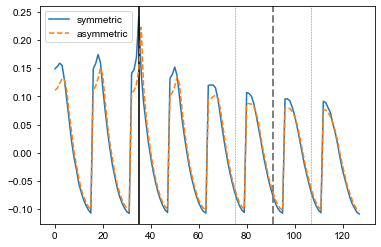

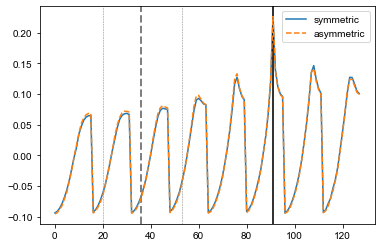

In [1254]:
## given we know the edge, can we estimate the correct edge weight?
# obj_lr.Linv_block["oo"][obj_lr.sp_graph.lre[0][0],obj_lr.sp_graph.lre[0][1]], obj_lr.Linv_block["oo"][obj_lr.sp_graph.lre[0][0],obj_lr.sp_graph.lre[0][0]], obj_lr.Linv_block["oo"][obj_lr.sp_graph.lre[0][1],obj_lr.sp_graph.lre[0][1]]
# plt.hist(np.diag(obj_lr.Linv_block["oo"]),20); plt.axvline(obj_lr.Linv_block["oo"][obj_lr.sp_graph.lre[0][0],obj_lr.sp_graph.lre[0][0]],ls='--',color='k')
# plt.plot(obj_sym.Linv_block["oo"][36,:],label='symmetric'); plt.axvline(36,color='k',linewidth=2,alpha=0.8); plt.axvline(91,ls='--',color='grey',linewidth=2); plt.axvline(75,ls='--',color='grey',linewidth=0.5);plt.axvline(107,ls='--',color='grey',linewidth=0.5);
# plt.plot(obj_asym.Linv_block["oo"][36,:],label='asymmetric',ls='--'); plt.legend(); plt.show()

# plt.plot(obj_sym.Linv_block["oo"][91,:],label='symmetric'); plt.axvline(91,color='k',linewidth=2,alpha=0.8); plt.axvline(36,ls='--',color='grey',linewidth=2); plt.axvline(20,ls='--',color='grey',linewidth=0.5);plt.axvline(53,ls='--',color='grey',linewidth=0.5);
# plt.plot(obj_asym.Linv_block["oo"][91,:],label='asymmetric',ls='--'); plt.legend()
# plt.plot(obj_lr.Linv_block["oo"][41,:]); plt.axvline(41,color='k',alpha=0.8);
# plt.imshow(obj_lr.Linv_block["oo"])
# fit_cov, _, emp_cov = comp_mats(obj_lr)
# plt.imshow(emp_cov-obj_lr.Linv_block["oo"])

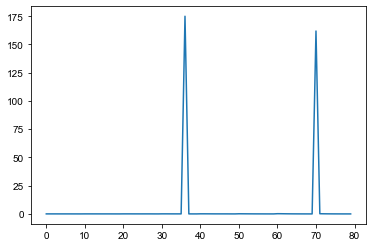

In [878]:
# [np.ravel(c*obj_lr.Linv_block["oo"][36,91]+(1-c)*np.dot(sp_graph_lr.adj_base.todense()[36,:],obj_lr.Linv_block["oo"][:,36])[0])[0] for c in cc]
plt.plot(obj_lr.Linv_block["oo"][70,])

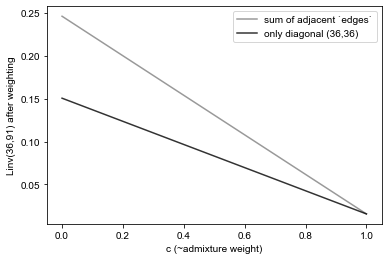

In [275]:
# cc = np.linspace(0,1,50)
plt.plot(cc,[np.ravel(c*obj_lr.Linv_block["oo"][36,91]+(1-c)*np.dot(sp_graph_lr.adj_base.todense()[36,:],obj_lr.Linv_block["oo"][:,36])[0])[0] for c in cc],color='grey',alpha=0.8,label='sum of adjacent `edges`'); plt.xlabel('c (~admixture weight)'); plt.ylabel('Linv(36,91) after weighting'); 
plt.plot(cc,[np.ravel(c*obj_lr.Linv_block["oo"][36,91]+(1-c)*obj_lr.Linv_block["oo"][36,36])[0] for c in cc],color='k',alpha=0.8, label='only diagonal (36,36)'); plt.legend()
# plt.axvline()
# obj_lr.Linv_block["oo"][36,91]

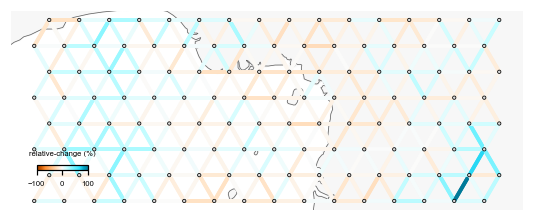

In [338]:
foldchange = (sp_graph_lr.w[~sp_graph_lr.lre_idx]-sp_Graph_def_jt.w)*100/sp_Graph_def_jt.w
fig = plt.figure(dpi=110) 
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_Graph_def_jt, projection=projection, edge_width=2.5, newweights=sp_graph_lr.w[~sp_graph_lr.lre_idx],
        edge_alpha=1, edge_zorder=100, sample_pt_size=2, halfrange=100,
        obs_node_size=1.5, sample_pt_color="black", cbar_ticklabelsize=5,
        cbar_font_size=5, cbar_width='10%',cbar_height='2.5%')
v.draw_map()
v.draw_edges(use_weights=True, use_foldchange=True)
v.draw_obs_nodes()
# v.draw_edge_colorbar()
v.draw_edge_change_colorbar()

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   4., 328.,   3.,   0.,   0.,   0.,   1.]),
 array([-37946.90366532, -35332.5359934 , -32718.16832148, -30103.80064956,
        -27489.43297764, -24875.06530572, -22260.69763379, -19646.32996187,
        -17031.96228995, -14417.59461803, -11803.22694611,  -9188.85927419,
         -6574.49160227,  -3960.12393035,  -1345.75625843,   1268.61141349,
          3882.97908541,   6497.34675733,   9111.71442925,  11726.08210117,
         14340.44977309]),
 <BarContainer object of 20 artists>)

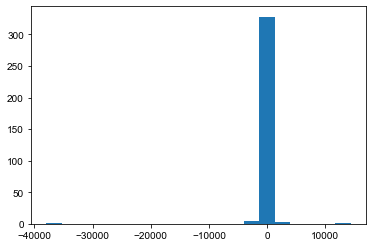

In [333]:
# np.corrcoef(v.weights[:10],sp_Graph_def_jt.w[:10])
# v.weights[:10], sp_Graph_def_jt.w[:10]
# list(np.column_stack(nx.adjacency_matrix(sp_Graph_def_jt).nonzero()))
# np.array(nx.adjacency_matrix(sp_Graph_def_jt).nonzero()).reshape(-1,2), 
# sp_Graph_def_jt.inv_triu(foldchange,perm=False)
# v.foldchange, list(np.column_stack(nx.adjacency_matrix(sp_Graph_def_jt).nonzero()))
# sp_graph_lr.w[0], sp_Graph_def_jt.w[0]
# plt.hist(v.foldchange); plt.hist(foldchange,alpha=0.9)
# plt.hist((sp_Graph_def_jt.w-np.mean(sp_Graph_def_jt.w))/np.std(sp_Graph_def_jt.w))
# plt.hist(np.log10(sp_Graph_def_jt.w)-np.mean(np.log10(sp_Graph_def_jt.w))); plt.hist(np.log10(sp_graph_lr.w)-np.mean(np.log10(sp_graph_lr.w)),alpha=0.6)
# norm_weights = (sp_Graph_def_jt.w - np.mean(sp_Graph_def_jt.w))/np.std(sp_Graph_def_jt.w)
# norm_newweights = (sp_graph_lr.w[~sp_graph_lr.lre_idx] - np.mean(sp_graph_lr.w[~sp_graph_lr.lre_idx]))/np.std(sp_graph_lr.w[~sp_graph_lr.lre_idx])
# plt.hist((norm_newweights-norm_weights)*100/norm_weights,20)
# plt.scatter(norm_weights, norm_newweights,color='grey',alpha=0.8)

In [337]:
# np.where(np.abs((norm_newweights-norm_weights)*100/norm_weights)>10000)
norm_newweights[166], norm_weights[166]

(-0.19775006113126983, -0.0013694176029042508)

Coding up this formula for different values of $c \in [0,1]$ and $\tau =\{5,25,50\}$ with $T'_{sd} = 500$ & $T'_{ss} = 20 (\ll T'_{sd})$ 

$T_{sd} = (1-c)T'_{sd} + c(2\tau + T'_{ss})$

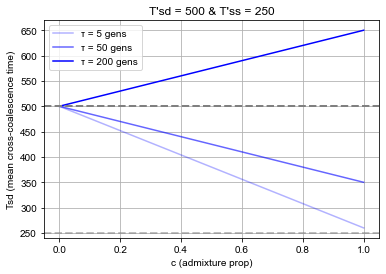

In [19]:
Tpsd = 500; Tpss = 250; c = np.linspace(0,1,20); tau = [5,50,200]
Tsd = (1-c)*Tpsd + c*(2*tau[0]+Tpss)
plt.plot(c, Tsd, color='blue', alpha=0.3, label='τ = 5 gens'); plt.ylabel('Tsd (mean cross-coalescence time)')
Tsd = (1-c)*Tpsd + c*(2*tau[1]+Tpss)
plt.plot(c, Tsd, color='blue', alpha=0.6, label='τ = 50 gens'); plt.title("T'sd = 500 & T'ss = 250"); plt.xlabel('c (admixture prop)'); 
Tsd = (1-c)*Tpsd + c*(2*tau[2]+Tpss)
plt.plot(c, Tsd, color='blue', alpha=1, label='τ = 200 gens'); plt.legend(); plt.grid()
plt.axhline(Tpsd, color='grey', ls='--', linewidth=2); plt.axhline(Tpss, color='grey', ls='--', alpha=0.5, linewidth=2); 
##########################################
# Tpsd = 500; Tpss = 20; tau = []
# Tsd = (1-c)*Tpsd + c*(2*tau[0]+Tpss)
# plt.plot(c, Tsd, color='deepskyblue', alpha=0.2, label='τ = 5 gens'); plt.ylabel('Tsd (mean cross-coalescence time)')
# Tsd = (1-c)*Tpsd + c*(2*tau[1]+Tpss)
# plt.plot(c, Tsd, color='deepskyblue', alpha=0.6, label='τ = 25 gens'); plt.title("T'sd = 500 & T'ss = 20"); plt.xlabel('c (admixture prop)'); 
# Tsd = (1-c)*Tpsd + c*(2*tau[2]+Tpss)
# plt.plot(c, Tsd, color='deepskyblue', alpha=1, label='τ = 50 gens'); plt.legend(); plt.grid()

### From msprime documentation: 

As described in the Definitions section, continuous migration between populations is modelled by a matrix of rates, so that $M[j, k]$ is the rate at which lineages move from population $j$ to population $k$ in the coalescent process, that is, backwards in time (see the Direction of time section for more details). Lineages that move from population $j$ to $k$ backwards in time actually correspond to individuals migrating from population $k$ to $j$ forwards in time.

Simulating ~SNP 0
Simulating ~SNP 900


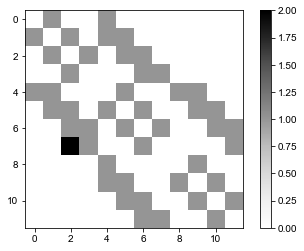

In [1217]:
# np.allclose(nx.adj_matrix(graph_def,weight="w").toarray().T-nx.adj_matrix(graph_def,weight="w").toarray())
# plt.imshow(np.array(nx.adj_matrix(graph,weight="w").todense().tolist()))
# migmat = np.array(nx.adj_matrix(graph_def,weight="w").todense().tolist())
gen_test1 = simulate_genotypes(graph_def, target_n_snps=1200, n_print=900, mu=1e-2, n_e=1, asymmetric=True, long_range_nodes=[(2,7)], long_range_edges=[2.])

### Computing the mean within-deme coalescent times

The relationship between off-diagonal elements of pseudo inverse of graph Laplacian and mean between-deme coalescent times are established: $T_{kl} \approx -dN_e L^\dagger_{kl} + N_e(2d+1)$. But how do the within-deme coalescent times relate to the diagonal elements (some kind of diversity measure)? 

Simulating ~SNP 0
Simulating ~SNP 900


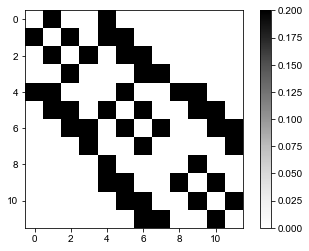

In [1335]:
graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=3, n_columns=4, corridor_w=.2, barrier_w=.2, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, n_samples_per_node=20, option=1)
# # graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=3, n_columns=3, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, ss=np.concatenate((np.repeat(10,4), np.repeat(20,5))), option=2)

gen_test1 = simulate_genotypes(graph_def, target_n_snps=1200, n_print=900, mu=1e-2, n_e=50)

mytree = []
for j in np.arange(1200): #np.random.randint(0,2500,500)
    mytree.append(tskit.load(f"results/trees/mytesttreeNe1s{j}.tree"))

In [1336]:
sp_Graph_def_jt = Joint_SpatialGraph(gen_test1,coord_def,grid_def,edge_def)
sp_Graph_def_jt.fit(lamb=3.,optimize_q='n-dim')
obj = Joint_Objective(sp_Graph_def_jt); obj.inv(); obj.grad(reg=False)

# fig = plt.figure(dpi=110)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_Graph_def_jt, projection=ccrs.Mercator(), edge_width=2, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
#         obs_node_size=7.5, sample_pt_color="black", 
#         cbar_font_size=10)
# v.draw_edges(use_weights=True)
# v.draw_edge_colorbar()
# v.draw_obs_nodes(use_ids=False)

constant-w/variance fit, converged in 154 iterations, train_loss=-13974.6211983
lambda=3.0000000, alpha=0.0802909, converged in 7 iterations, train_loss=-14025.5821299


In [1092]:
# def comp_fst_mat(genotypes, n_inds, n_demes):
#     """Computes an Fst distance matrix from a sample
#     genotype matrix and set of sub-population ids
#     """
#     n_snps = genotypes.shape[1]
#     acs = np.empty((n_demes, n_snps, 2))
    
#     # compute allele counts
#     for i in range(n_demes):
#         Gi = genotypes[np.arange(i*n_inds,(i+1)*n_inds), :]
#         acs[i, :, 0] = np.sum(Gi, axis=0)
#         acs[i, :, 1] = (2 * Gi.shape[0]) - np.sum(Gi, axis=0) 
    
#     # compute Fst matrix
#     Fst = np.empty((n_demes, n_demes))
#     for i in range(n_demes):
#         for j in range(n_demes):
#             Fst[i, j] = np.sum(allel.mean_pairwise_difference_between(acs[i, :, :].astype(np.int32), acs[j, :, :].astype(np.int32)))/n_snps

#     for i in range(n_demes):
#         Fst[i, i] = np.sum(allel.mean_pairwise_difference(acs[i, :, :].astype(np.int32)))/n_snps
#     return(Fst)

Fst = comp_fst_mat(gen_test1,20,12)

True

In [346]:
# def avg_coal_time(tree):
#     coalescence_time = 0
#     sample_size = tree.get_sample_size()
#     for leaves in tree.samples():
#         num_branch = 0
#         u = leaves
#         visited = np.array([u])
#         while u != tskit.NULL:
#             u = tree.parent(u)
#             if u !=-1 :
#                 node_children = np.array(tree.children(u))
#                     #print("{}:{}".format(u, node_children))                                                                                               
#                 node_interest = np.setdiff1d(node_children, visited)
#                 if len(node_interest)!=0:
#                     for j in range(len(node_interest)):
#                         num_leaves = tree.get_num_leaves(node_interest[j])
#                         node_branch_len = tree.time(u) * num_leaves
#                         coalescence_time = coalescence_time + node_branch_len
#                         visited = np.append(visited, u)
#                         num_branch =+ num_leaves

#         #print("leaves{}:{},{}".format(leaves, num_branch, visited))                                                                                       
#     return(coalescence_time/(sample_size * (sample_size-1)))

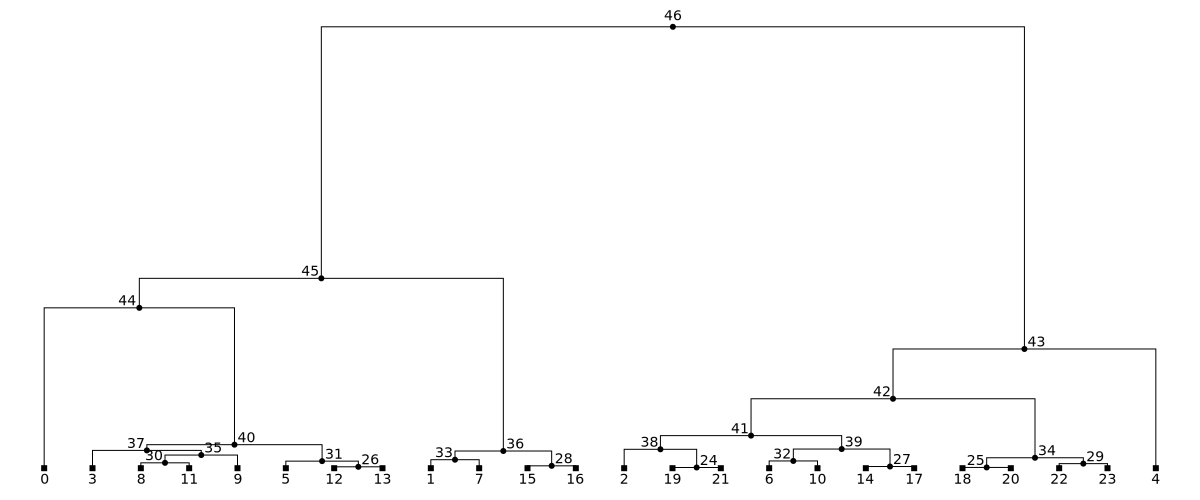

In [458]:
## checking if the code below works correctly
# tt = mytree[1].first()
# [tt.tmrca(0,j) for j in range(8)]
from IPython.display import SVG
SVG(mytree[9].first().draw_svg(size=(1200,500)))
# mytree[1].first().num_samples()

In [447]:
[mytree[345].first().tmrca(0,j) for j in range(8)]

[0.0,
 0.0021556037810076833,
 17.232796330874926,
 18.49212492108312,
 7.8402741613046025,
 7.8402741613046025,
 18.49212492108312,
 0.7358143044454222]

In [714]:
# coaltimemat
list(nx.get_node_attributes(graph_def,"sample_size").values())

[10, 10, 10, 10, 20, 20, 20, 20, 20]

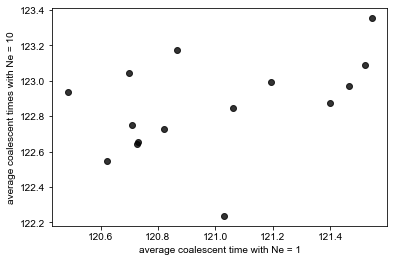

In [412]:
# np.polyfit(np.ravel(coaltimematNe1[np.tril_indices_from(coaltimemat,-1)]),np.ravel(coaltimemat[np.tril_indices_from(coaltimemat,-1)]),deg=1)
plt.scatter(coaltimematNe1[np.tril_indices_from(coaltimematNe1,-1)],coaltimemat[np.tril_indices_from(coaltimemat,-1)],color='k',alpha=0.8,); 
plt.xlabel('average coalescent time with Ne = 1'); plt.ylabel('average coalescent times with Ne = 10'); plt.autoscale()
# plt.axline((0,0),slope=1,color='grey',ls='--',label='({},{})'.format(1.0,161)); plt.legend(); 

In [407]:
np.triu_indices_from(coal,1)

(array([0, 0, 0, 1, 1, 2]), array([1, 2, 3, 2, 3, 3]))

In [1337]:
## code for calculating average coalescent time between & within demes for equal # of inds in demes
ndemes = 12; ninds = 2*20; nsnps = 1200
coaltimemat = np.zeros((ndemes,ndemes))
for snp in range(nsnps):
    tt = mytree[snp].first()
    for i in range(ninds*ndemes):
        for j in range(i+1,ninds*ndemes):
            coaltimemat[int(i/ninds),int(j/ninds)] += tt.tmrca(i,j)

coaltimemat[np.diag_indices_from(coaltimemat)] /= np.sum(range(ninds))
coaltimemat[np.triu_indices_from(coaltimemat,1)] /= ninds*ninds

## code for calculating average coalescent time between & within demes for different # of inds in demes
# ss = np.array(list(nx.get_node_attributes(graph_def,"sample_size").values())); 
# ndemes = len(ss); nsnps = 2000
# coaltimemat = np.zeros((ndemes,ndemes))
# for snp in range(nsnps):
#     tt = mytree[snp].first()
#     for d1 in range(ndemes):
#         for d2 in range(d1,ndemes):
#             for i in range(ss[d1]):
#                 for j in range(ss[d2]):
#                     coaltimemat[d1,d2] += tt.tmrca(i+np.sum(ss[:d1]),j+np.sum(ss[:d2]))

# for d1 in range(ndemes):
#     for d2 in range(d1,ndemes):
#         if d1 != d2:
#             coaltimemat[d1,d2] /= ss[d1]*ss[d2]
#         else:
#             coaltimemat[d1,d1] /= np.sum(range(ss[d1]))

coaltimemat = coaltimemat + coaltimemat.T
coaltimemat[np.diag_indices_from(coaltimemat)] *= 0.5
coaltimemat /= nsnps #*0.5/Ne

In [1325]:
# np.polyfit(obj.Linv[np.tril_indices_from(obj.Linv,-1)], coaltimemat[np.tril_indices_from(coaltimemat,-1)], deg=1, full=True)
# plt.scatter(np.ravel(coaltimematxx),np.ravel(coaltimemat*2*10),alpha=0.7,color='k'); #plt.axline((150,150),slope=1,ls='--',color='grey')
# plt.ylabel('average coalescent time with Ne=10'); plt.xlabel('rescaled average coalescent time with Ne=1')

0.26460506351167445

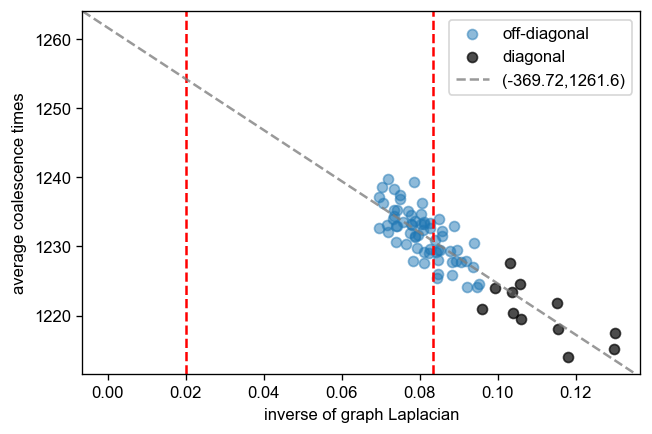

In [1340]:
fig = plt.figure(dpi=120)
plt.scatter(obj.Linv[np.tril_indices_from(obj.Linv,-1)],coaltimemat[np.tril_indices_from(coaltimemat,-1)], alpha=0.5, label='off-diagonal'); 
# m1, b1 = np.polyfit(coaltimemat[np.tril_indices_from(coaltimemat,-1)], obj.Linv[np.tril_indices_from(obj.Linv,-1)], deg=1)
# plt.plot(np.linspace(np.min(coaltimemat),np.max(coaltimemat)), b1+m1*np.linspace(np.min(coaltimemat),np.max(coaltimemat)), ls='--', label='({:.2f},{:.1f})'.format(m1,b1), alpha=0.6)
plt.scatter(np.diag(obj.Linv), np.diag(coaltimemat), color='k', alpha=0.7, label='diagonal'); 
plt.axvline(1/ndemes,color='red',ls='--'); plt.axvline(1/50,color='red',ls='--'); 
# m2, b2 = np.polyfit(np.diag(coaltimemat), np.diag(obj.Linv), deg=1)
# plt.axline((0,b2),slope=m2,color='grey',ls='--',alpha=0.6,label='({:.2f},{:.1f})'.format(m2,b2))
m3, b3 = np.polyfit(obj.Linv[np.tril_indices_from(obj.Linv)],coaltimemat[np.tril_indices_from(coaltimemat)], deg=1); 
plt.axline((0.0,b3),slope=m3, ls='--', label='({:.2f},{:.1f})'.format(m3,b3), alpha=0.8, color='grey')
plt.ylabel('average coalescence times'); plt.xlabel('inverse of graph Laplacian'); plt.legend(); #plt.xlim((np.min(obj.Linv),np.max(obj.Linv)))

In [919]:
np.sqrt((((-9*obj.Linv[np.tril_indices_from(obj.Linv)]+19)-coaltimemat[np.tril_indices_from(coaltimemat)])**2).mean(axis=None)/(((m3*obj.Linv[np.tril_indices_from(obj.Linv)]+b3)-coaltimemat[np.tril_indices_from(coaltimemat)])**2).mean(axis=None))
# np.corrcoef(coaltimemat[np.tril_indices_from(coaltimemat)],m3*obj.Linv[np.tril_indices_from(obj.Linv)]+b3)[0,1]**2

25.46836522645117

In [1287]:
## code to calculate Rab = 1/Cab = 1/Mab = (Tab - (Taa+Tbb)/2)/((Taa+Tbb)/8)
rab_coal, tauab, rab_ldag, rab_ldag2 = [], [], [], []
for a in range(ndemes):
    for b in range(a+1,ndemes):
        rab_coal.append((coaltimemat[a,b]-0.5*(coaltimemat[a,a]+coaltimemat[b,b]))/(0.125*(coaltimemat[a,a]+coaltimemat[b,b])))
        rab_ldag.append(-2*obj.Linv[a,b]+obj.Linv[a,a]+obj.Linv[b,b])
        rab_ldag2.append(-2*newLinv[a,b]+newLinv[a,a]+newLinv[b,b])
        tauab.append(coaltimemat[a,b]-0.5*(coaltimemat[a,a]+coaltimemat[b,b]))

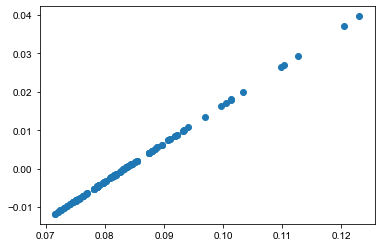

In [1178]:
# newLinv = obj.Linv - obj.Linv.mean(axis=1)[:,None]
plt.scatter(np.ravel(obj.Linv), np.ravel(newLinv))

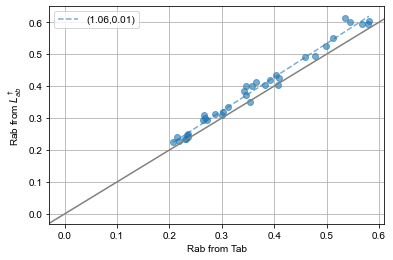

In [1288]:
m1, b1 = np.polyfit(rab_coal, rab_ldag, deg=1)
plt.plot(np.linspace(np.min(rab_coal),np.max(rab_coal)), b1+m1*np.linspace(np.min(rab_coal),np.max(rab_coal)), ls='--', label='({:.2f},{:.2f})'.format(m1,b1), alpha=0.6); plt.legend(); plt.ylabel(r'Rab from $L_{ab}^\dagger$'); plt.xlabel('Rab from Tab'); plt.grid()
plt.scatter(rab_coal,rab_ldag,alpha=0.6); plt.axline((0,0),slope=1,color='grey'); 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


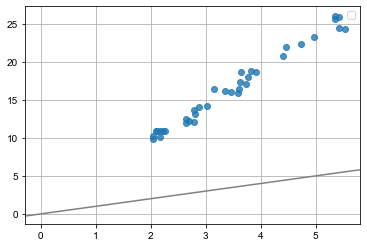

In [1290]:
# plt.scatter(np.ravel(coaltimemat[np.triu_indices_from(coaltimemat,1)]),ndemes/4*np.array(rab_coal),color='k'); plt.grid()
# meantmrca = 0
# for i in range(ndemes):
#     for j in range(i+1,ndemes):
#         meantmrca += 0.125*(coaltimemat[i,i]+coaltimemat[j,j])
# print(meantmrca*2/(ndemes*(ndemes-1)))
# m, b = np.polyfit(rab_coal,tauab,deg=1)
## for ndemes = d = 12:
# plt.scatter(rab_coal,np.array(tauab)/6,alpha=0.8,label=r'$\tau_{{ab}}$, slope = {:.1f}, int = 0'.format(ndemes/2)); plt.xlabel('$R_{ab}$'); 
# plt.scatter(rab_coal,-(np.ravel(obj.Linv[np.triu_indices_from(obj.Linv,1)])-0.16)/0.24,alpha=0.8,label='$L^\dagger_{{ab}}$, slope = {:.2f}, int = {:.2f}'.format(-0.24,0.16)); plt.axline((0,0),slope=1,color='grey',ls='--'); plt.legend(); plt.grid()
## for ndemes = d = 9 & Ne = 1: 
plt.scatter(np.array(rab_ldag)*ndemes,tauab,alpha=0.8)
# plt.scatter(rab_coal,np.array(tauab)/450,alpha=0.8,label=r'$\tau_{{ab}}$, slope = {:.2f}, int = 0'.format(45)); plt.xlabel('$R_{ab}$'); 
# plt.scatter(rab_coal,-(np.ravel(obj.Linv[np.triu_indices_from(obj.Linv,1)])-0.111111)/0.5,alpha=0.8,label='$L^\dagger_{{ab}}$, slope = {:.2f}, int = {:.2f}'.format(-0.3,0.12)); 
plt.axline((0,0),slope=1,color='grey'); plt.legend(); plt.grid()
## for ndemes = d = 9 & Ne = 10: 
# plt.scatter(rab_coal,tauab,alpha=0.8,label=r'$\tau_{{ab}}$, slope = {:.1f}, int = 0'.format(3.)); plt.xlabel('$R_{ab}$'); 
# plt.scatter(rab_coal,-(np.ravel(obj.Linv[np.triu_indices_from(obj.Linv,1)])-0.1175)/0.24,alpha=0.8,label='$L^\dagger_{{ab}}$, slope = {:.2f}, int = {:.2f}'.format(-0.26,0.12)); plt.axline((0,0),slope=3,color='grey',ls='--'); plt.legend(); plt.grid()

In [1083]:
print(np.polyfit(obj.Linv[np.triu_indices_from(obj.Linv,1)],tauab,deg=1))
print(np.polyfit(rab_coal,obj.Linv[np.triu_indices_from(obj.Linv,1)],deg=1))
print(np.polyfit(np.ravel(obj.Linv),np.ravel(coaltimemat),deg=1))
print(np.polyfit(tauab,coaltimemat[np.triu_indices_from(coaltimemat,1)],deg=1))
# print(np.polyfit(obj.Linv[np.triu_indices_from(obj.Linv)],coaltimemat[np.triu_indices_from(coaltimemat)], deg=1)) -> same as for k=1
print("")
print(np.polyfit(obj.Linv[np.triu_indices_from(obj.Linv,1)],rab_ldag,deg=1))
print(np.polyfit(rab_ldag,tauab,deg=1))

[-99.68141166  10.29351013]
[-0.32573714  0.09337111]
[-85.50453368 245.30105057]
[  0.33079553 237.63292401]

[-2.43220209  0.24737059]
[40.31193283  0.18868992]


In [944]:
# print(np.polyfit(obj.Linv[np.triu_indices_from(obj.Linv,1)],rab_coal,deg=1))
# a, b = 2, 7
# np.sum(obj.Linv[2,list(set(range(9))-set([2,7]))])+ np.sum(obj.Linv[7,list(set(range(9))-set([2,7]))])
sp_Graph_def_jt.L.todense()

matrix([], shape=(0, 0), dtype=float64)

In [1146]:
## reading in trees from SLiM (https://github.com/petrelharp/isolation_by_coalescence)
# origts = tskit.load("/Users/vivaswat/feems/docs/notebooks/results/slimtrees/pop_10000.trees")
origtree = []
for t in origts.trees():
    origtree.append(t)

In [1185]:
# from IPython.display import SVG
# SVG(origtree[9].first().draw(size=(1200,500)))

AttributeError: 'Tree' object has no attribute 'num_individuals'

In [607]:
# print(np.polyfit(tauab,np.ravel(coaltimemat[np.tril_indices_from(coaltimemat,-1)]),deg=1))
# np.ravel(coaltimemat[np.triu_indices_from(coaltimemat,k=1)])
# 0.125*(coaltimemat[1,1]+coaltimemat[2,2]), 0.125*(coaltimemat[1,1]+coaltimemat[3,3]), 0.125*(coaltimemat[6,6]+coaltimemat[2,2])

53

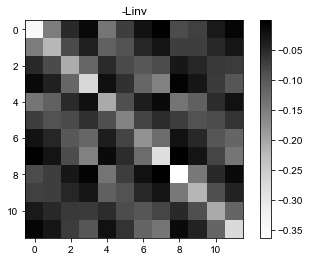

In [1225]:
# plt.imshow(coaltimemat,cmap='Greys'); plt.title('coalescent time'); plt.colorbar(); plt.show()
plt.imshow(-obj.Linv,cmap='Greys',); plt.title('-Linv'); plt.colorbar(); plt.show()
# plt.imshow(comp_fst_mat(gen_test,10,9), cmap='Greys')

In [1142]:
## rolling my own waiting times script (derived from https://arxiv.org/pdf/1908.09644v1.pdf)
def get_mean_and_variance(transition_matrix):
    row, col = transition_matrix.shape
    assert(row == col)
    dimension = row
    row_indices = range(dimension)
    col_indices = [0] * dimension
    data = [1] * dimension
    ones = sp.sparse.csr_matrix((data, (row_indices, col_indices)), shape = (dimension, 1))
    eps = 1.0e-13
    expectation = ones#sp.sparse.csr_matrix((data, (row_indices, col_indices)), shape = (dimension, 1))
    variance = sp.sparse.csr_matrix(([0] * dimension, (row_indices, col_indices)), shape = (dimension, 1))
    power = ones #sp.sparse.csr_matrix((data, (row_indices, col_indices)), shape = (dimension, 1))
    expansion_order = 22
    counter = 0
    while counter < expansion_order:
        counter += 1
        power = transition_matrix * power
        expectation += power
        variance += counter * power
        error = np.linalg.norm(expectation.todense())
        if error < eps:
            break
    variance = 2.0 * variance
    variance = variance + expectation - expectation.multiply(expectation)
    return expectation, variance

In [1143]:
rezexp, rezvar = get_mean_and_variance(nx.adj_matrix(graph_def,weight="w"))
rezvar.todense()

matrix([[-1.64784917e+27],
        [-6.95502952e+27],
        [-8.67556413e+27],
        [-3.98441368e+27],
        [-7.96889947e+27],
        [-1.73511640e+28],
        [-1.39099756e+28],
        [-3.29565931e+27],
        [-1.64784917e+27],
        [-6.95502952e+27],
        [-8.67556413e+27],
        [-3.98441368e+27]])